# Neural Network Classifier for Particle Physics

In this exercise, we'll build a PyTorch binary classifier DNN, and apply this DNN to separating a Higgs Boson signal from a background process.

The signal process is a Higgs Boson decaying to two leptons among other stuff. The background process is a pair of top quarks decaying to a very similar final state, two leptons plus other particles, that look on a first glance essentially the same in the detector.

Each dataset contains 26 features related to the particles detected in each case.

In [1]:
import h5py
import pandas as pd
import numpy as np
import torch

## Importing Data

The first thing to do is to load your data. It is provided for you on CERNBox. You should be able to access it. If problems arise, contact one of the tutors.

So, to download the input data execute the next code block.

In [2]:
url = "https://cernbox.cern.ch/remote.php/dav/public-files/icjK5HWChdTcdb2/WW_vs_TT_dataset.h5"

import requests
import io

# download
response = requests.get(url)
response.raise_for_status() # Check for download errors

# load into a in-memory binary stream
H_vs_TT_dataset = io.BytesIO(response.content)


The data is stored in `h5` format which is the industry standard for storing numpy arrays in machine learning contexts.

The file contains two datasets, `Signal` and `Background`. Each dataset is an array of shape N x 26, where N is the number of separate proton-proton collisions (we call these "events") and 26 refers to the number of features stored in that file.

We can load both datasets as [pandas](https://pandas.pydata.org/docs/user_guide/index.html) dataframes.

In [3]:
# Load file
file = h5py.File(H_vs_TT_dataset, 'r')

# Extract data
df_signal       = pd.DataFrame(file['Signal'][:])
df_background   = pd.DataFrame(file['Background'][:])

## Data Visualisation

As we stated in the lectures, it's useful to understand the input parameters and compare them between the different classes to get a feeling for the actual task.

Remember you are supposed to design a classifier that

The following function can be used to draw histograms of a certain feature for the two classes in order to compare them.

In [4]:
import matplotlib.pyplot as plt
def compare_distributions(signal_data, background_data, variable_name):
    plt.figure(figsize=(10, 6),dpi=100)
    plt.hist(signal_data[variable_name], bins=40,  histtype='step', label='Signal', density=True)
    plt.hist(background_data[variable_name], bins=40, histtype='step', label='Background', density=True)
    plt.xlabel(variable_name)
    plt.ylabel('Density')
    plt.title(f'Distribution of {variable_name}')
    plt.legend()
    plt.show()

Just as an exaple let's have a look at one of the leptons' energy.

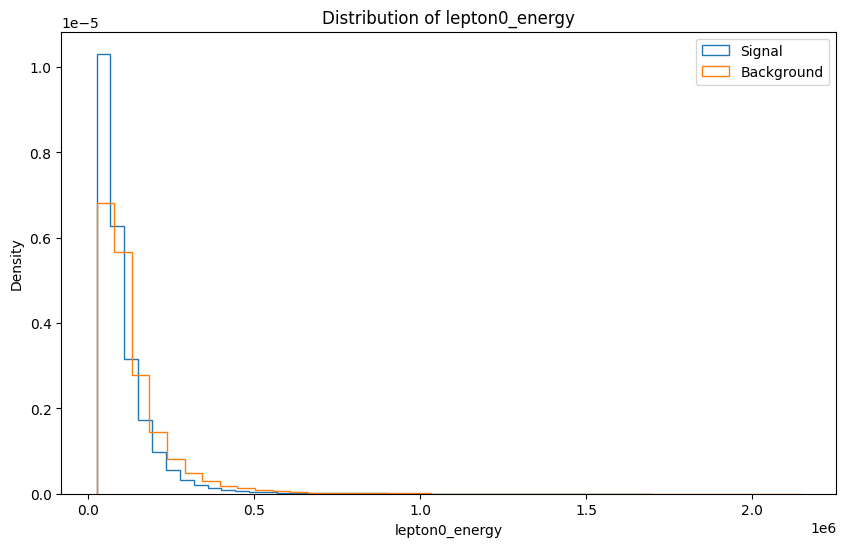

In [5]:
compare_distributions(df_signal, df_background, 'lepton0_energy')

#### Question!

Do you think with this information alone you could reliably distinguish between signal and background?

As you can see, there are some differences in the feature distributions comparing the two classes. But they aren't huge and overlap quite a bit. So a classifier using this would probably not suffice for anything practical. You have to include addiditonal information.

Here is a list of all the other features stored in the dataset:
```python
['lepton0_px', 'lepton0_py', 'lepton0_pz', 'lepton0_energy',
'lepton1_px', 'lepton1_py', 'lepton1_pz', 'lepton1_energy',
'jet0_px', 'jet0_py', 'jet0_pz', 'jet0_energy',
'jet1_px', 'jet1_py', 'jet1_pz', 'jet1_energy',
'Njets', 'HT_all', 'MissingEnergy',
'lepton0_mass', 'lepton1_mass', 'jet0_mass', 'jet1_mass', 'combined_leptons_mass',
'angle_between_jets', 'angle_between_leptons']
```
Try to plot some of them and pick the ones you think are suitable for separating the signal from background.

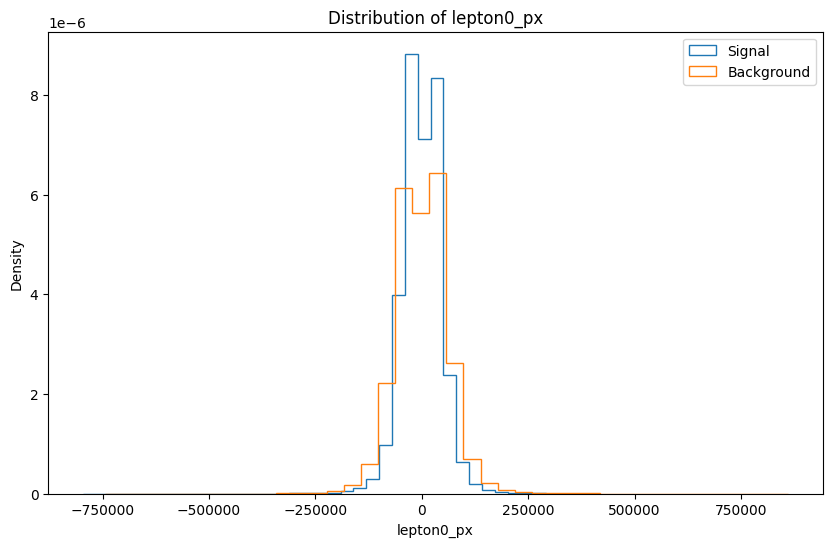

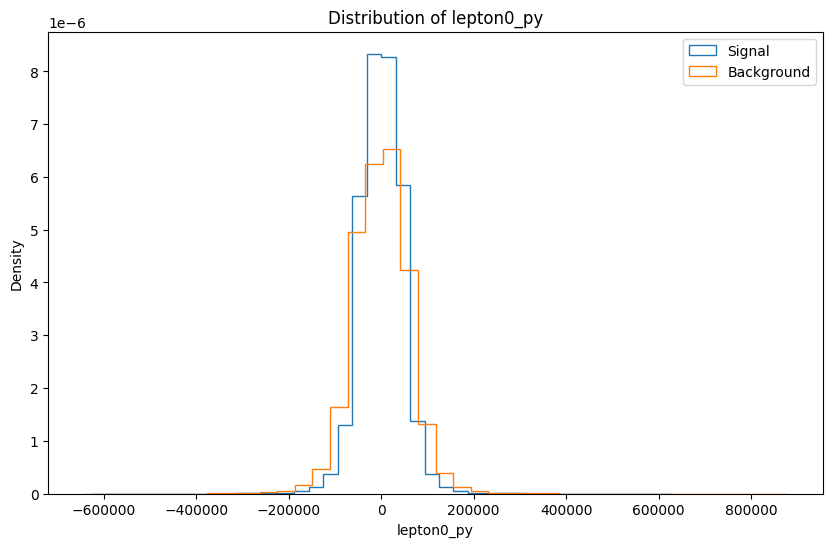

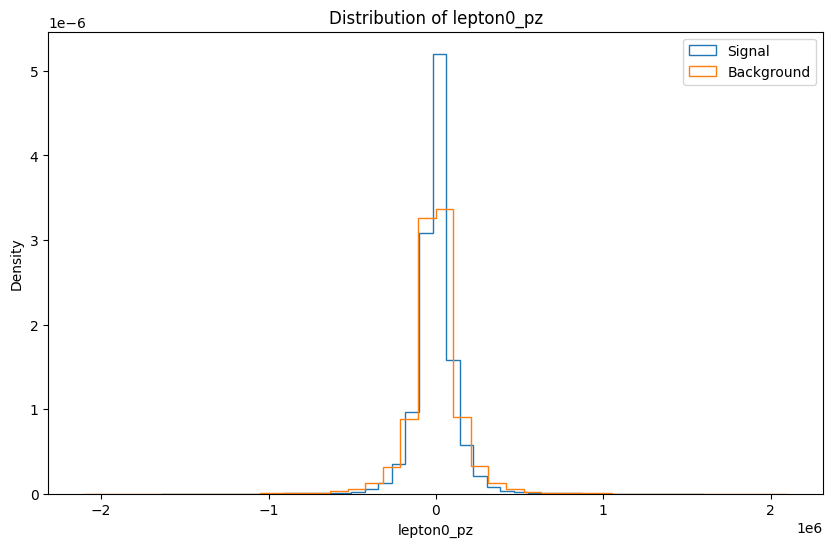

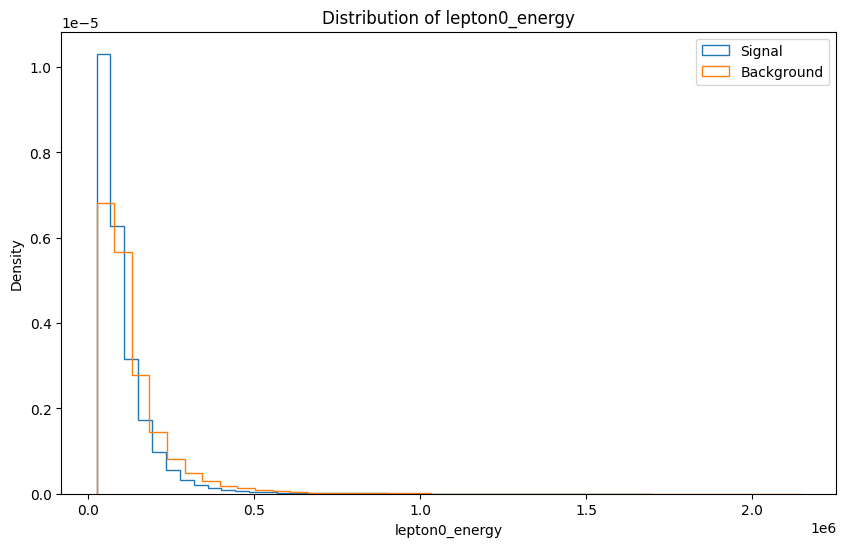

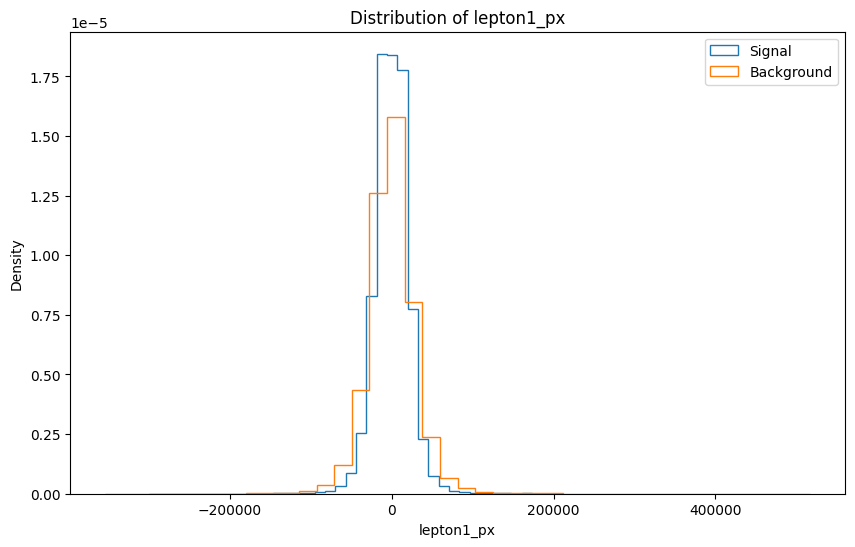

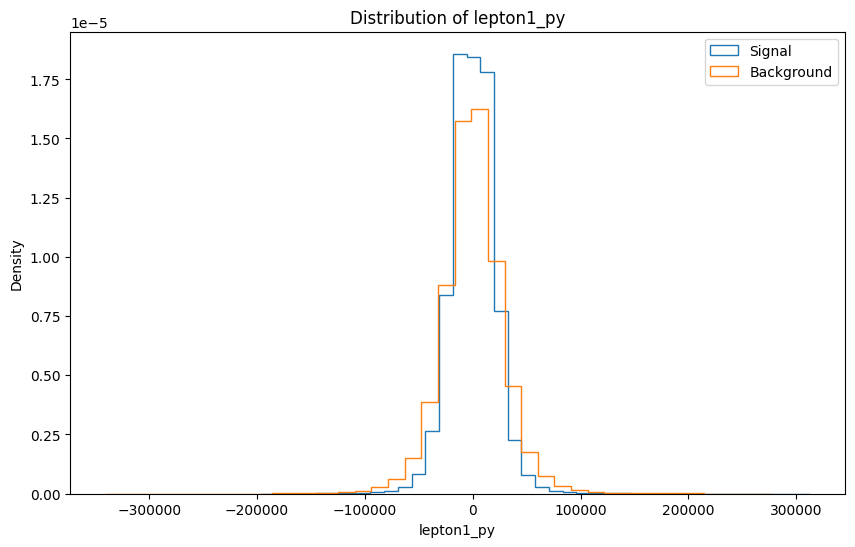

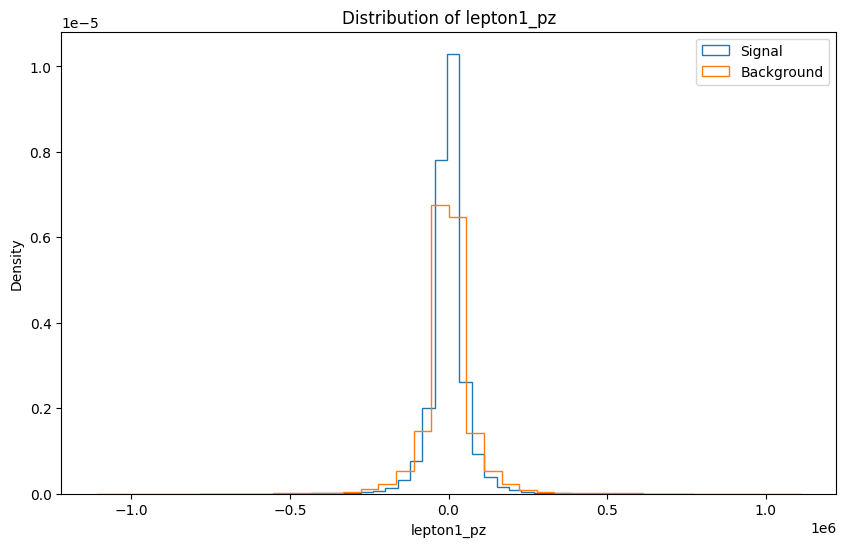

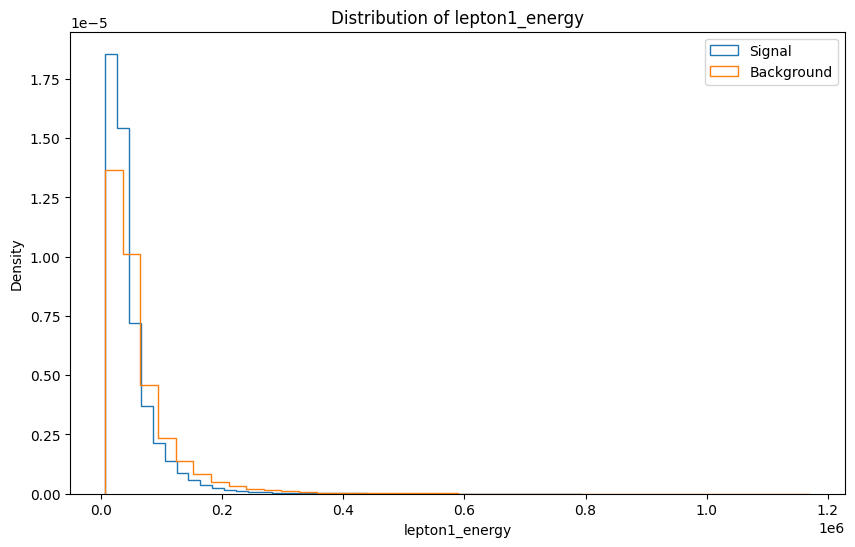

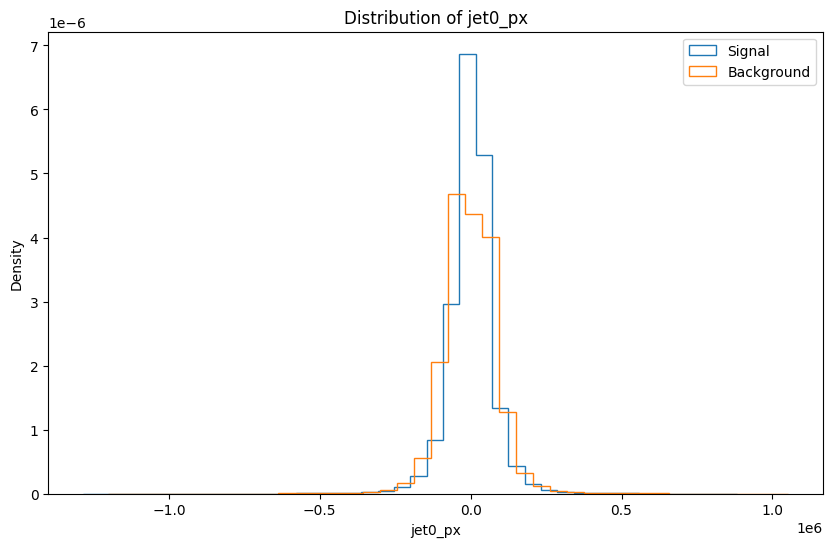

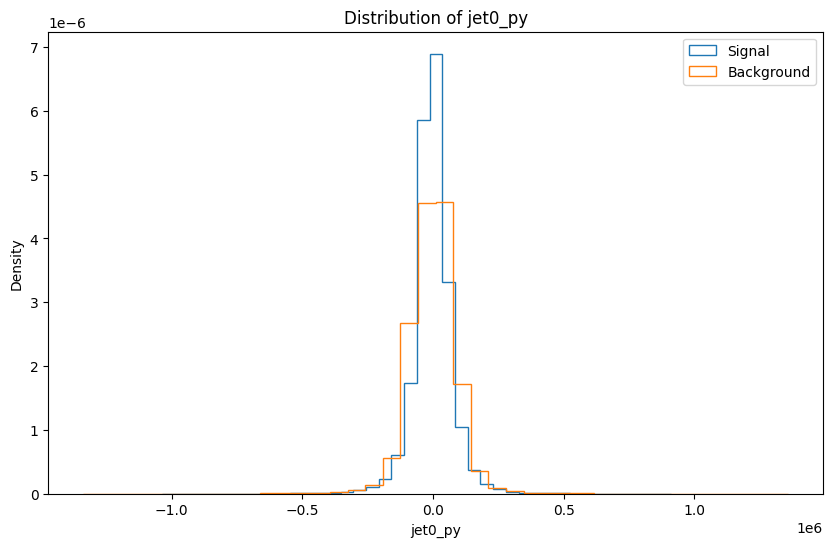

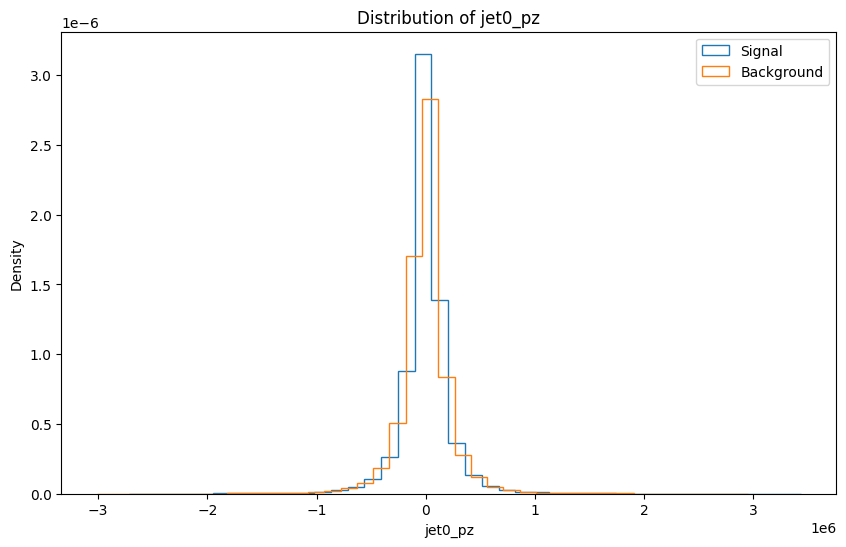

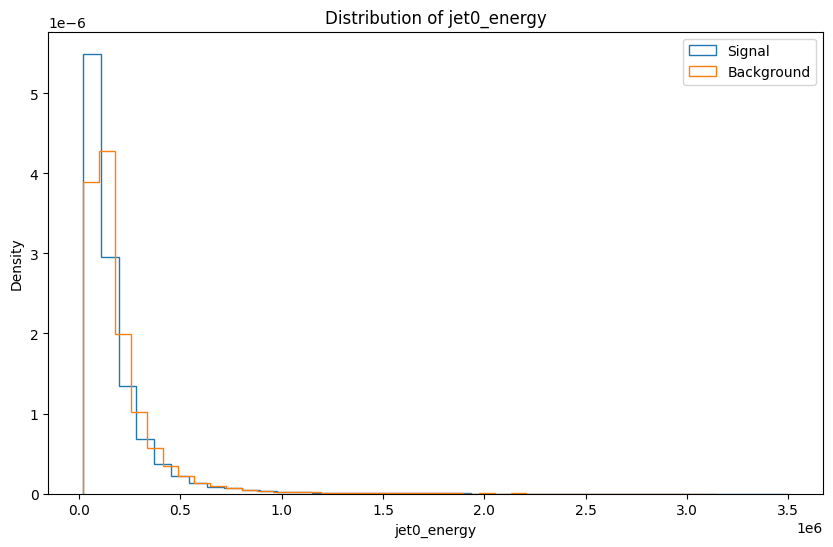

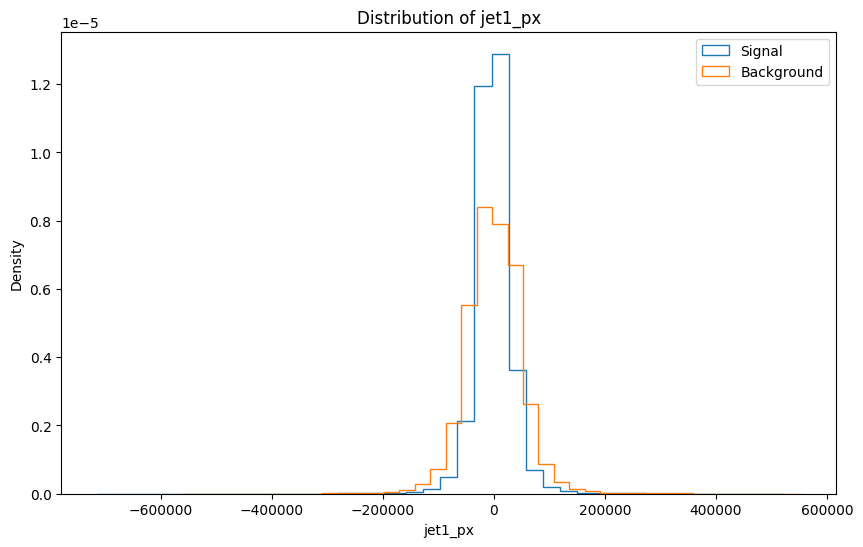

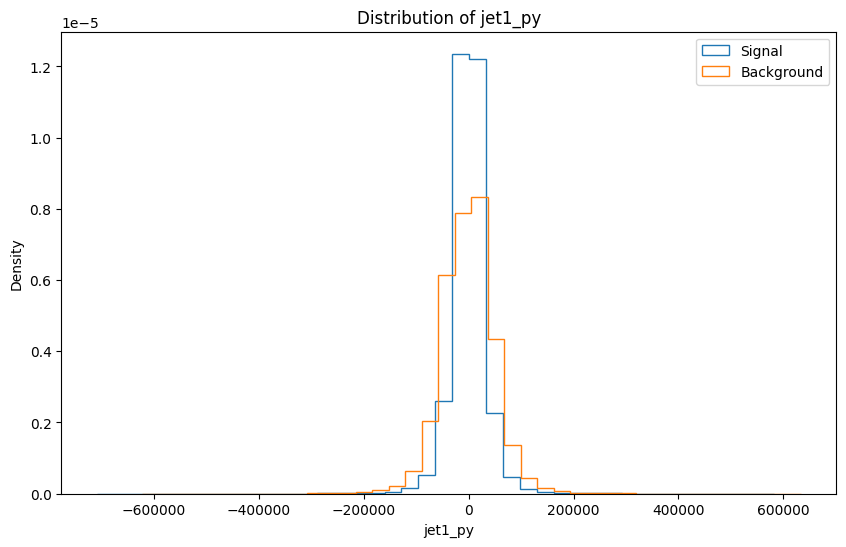

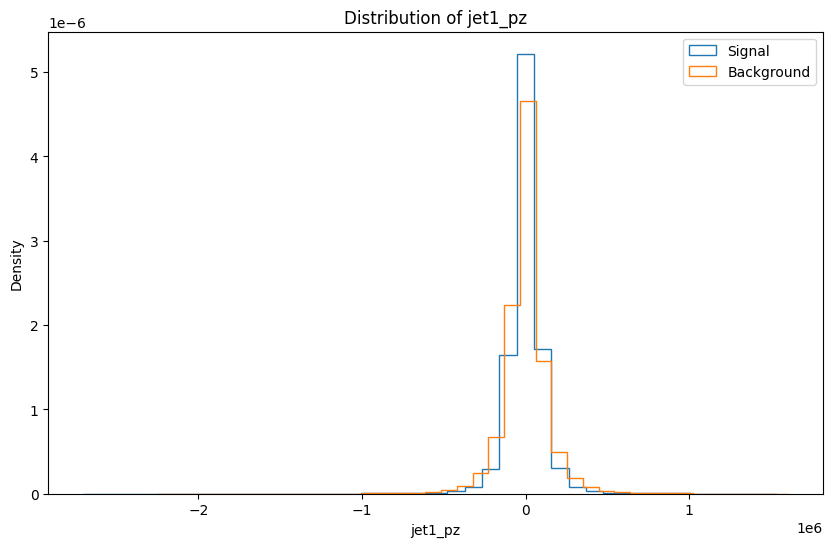

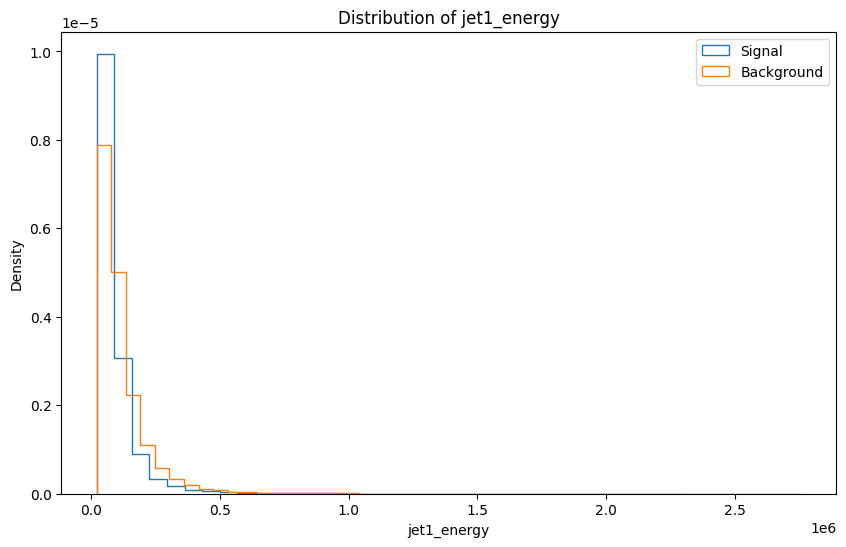

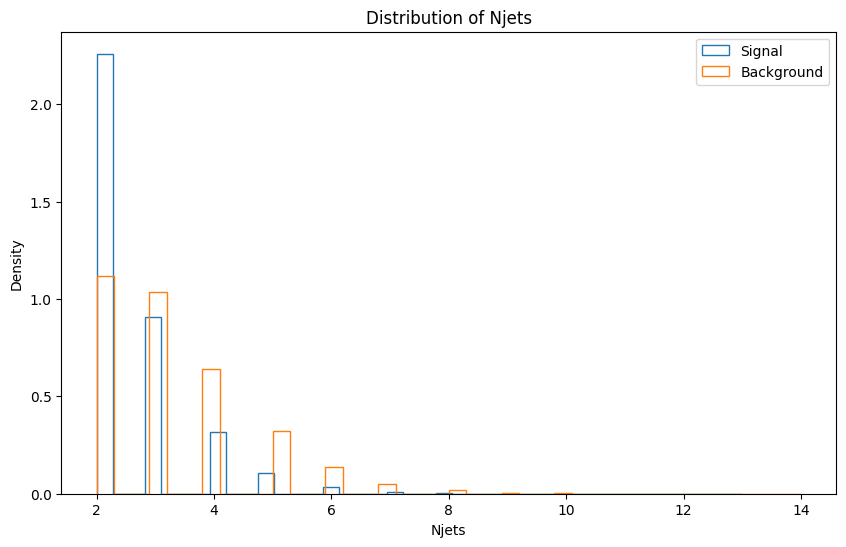

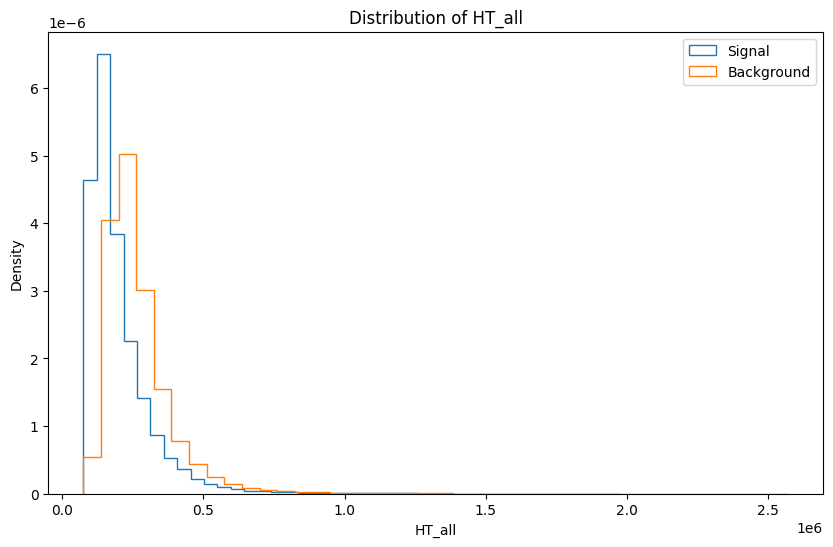

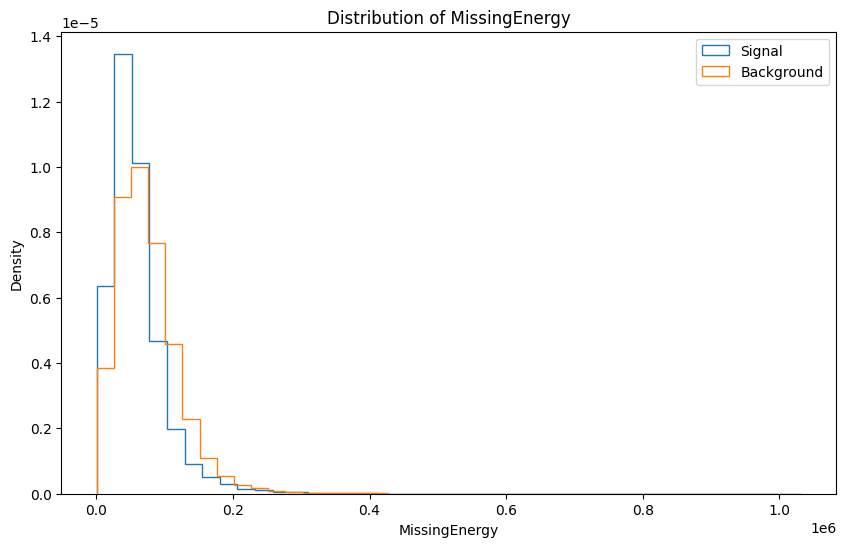

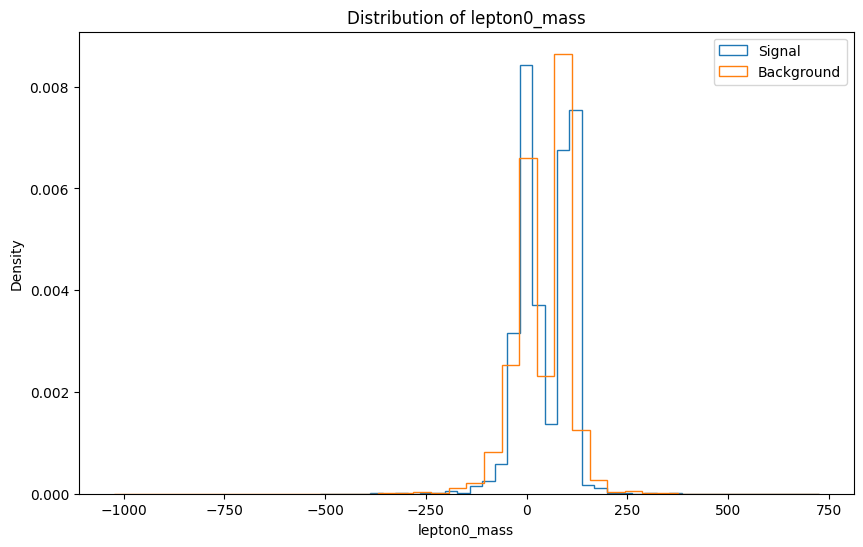

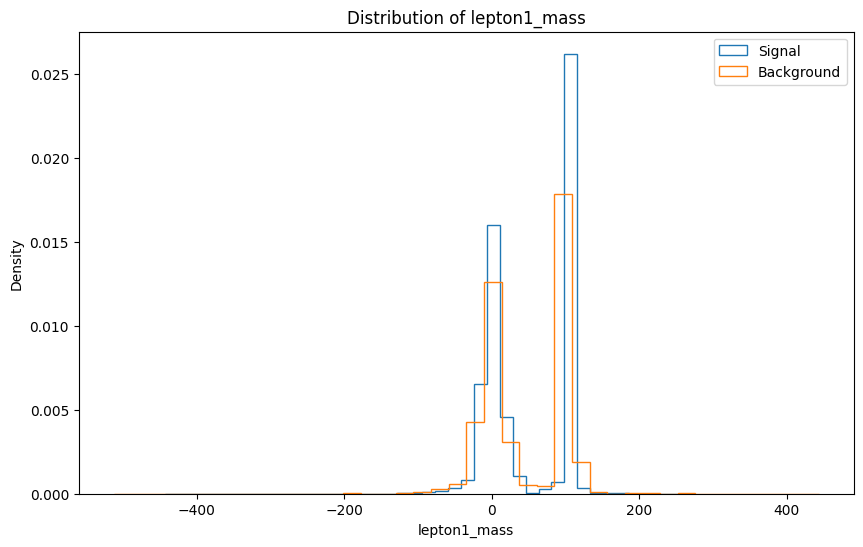

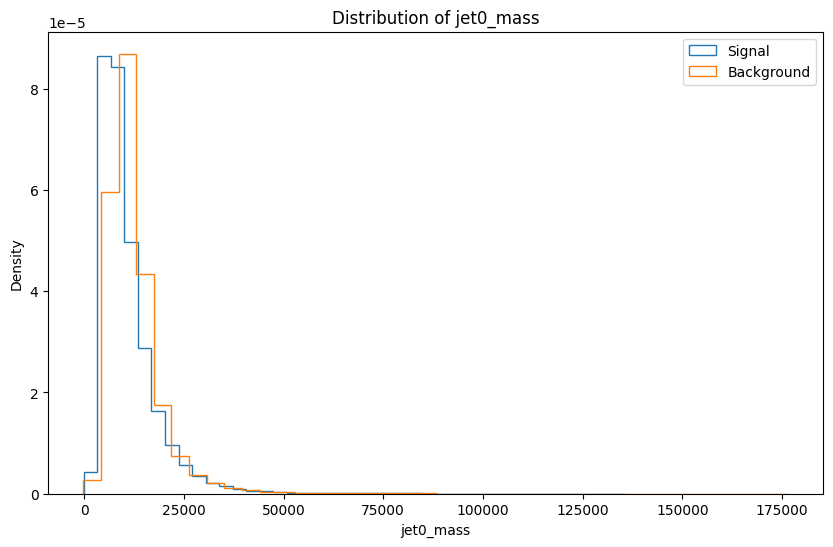

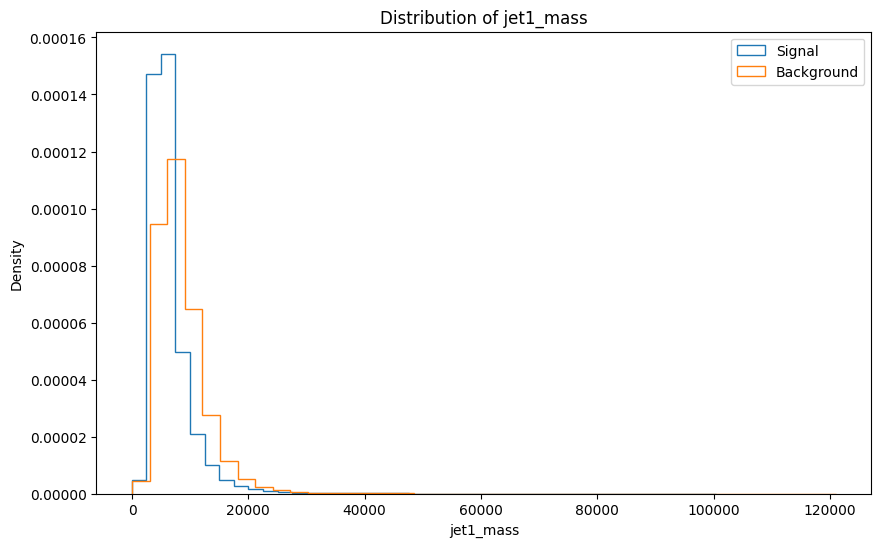

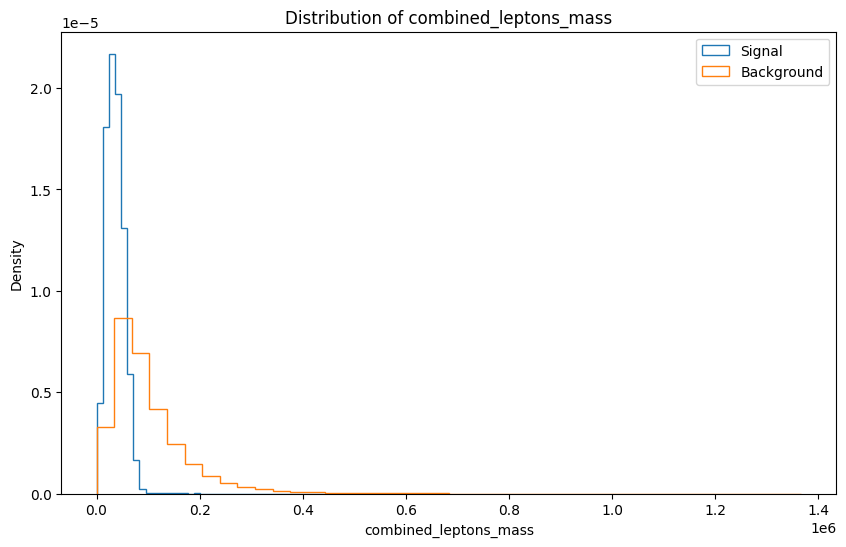

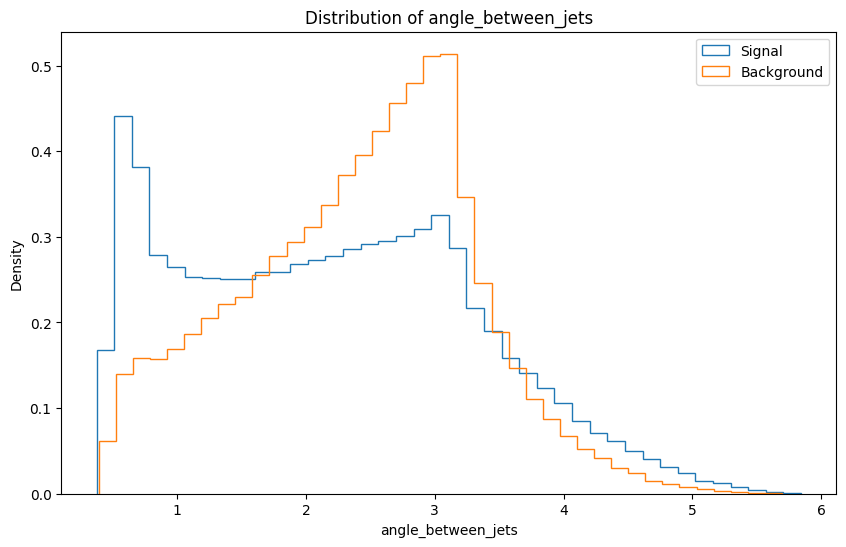

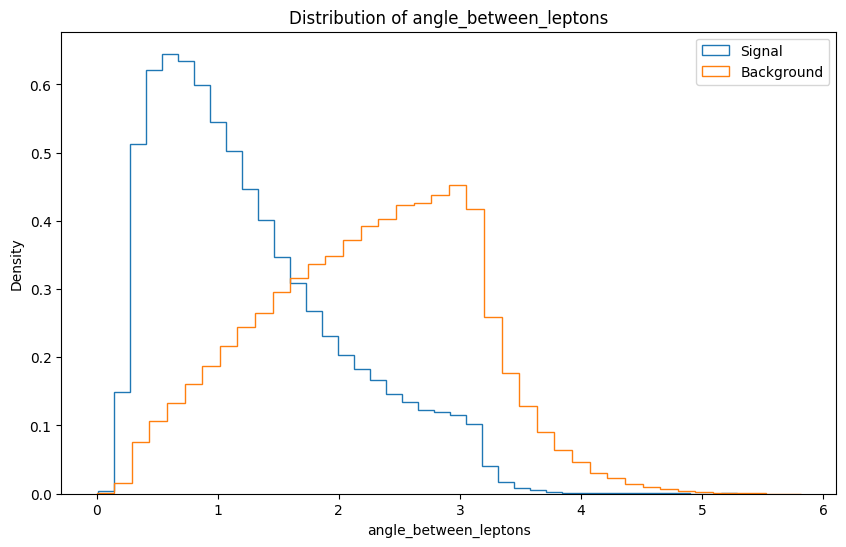

In [6]:
list_of_selected_features = df_signal.columns
for feature in list_of_selected_features:
    compare_distributions(df_signal, df_background, feature)

## Data Preparation Task

Now, since you have a feeling for the input data now, it is time to become active:

1. Create two arrays based on the `input_features` you wish to train on. We have to use the same features for signal and background.
2. Create the targets for the learning: Label 0 for background, and label 1 for signal. Hint:
3. Concatenate the signal and background input data filtered for the features you would like to use into one big `input_data` array. Do the same for the targets. Shuffle the numpy arrays. Careful: Do not shuffle before you have connected the targets to the `input_data`.
4. Split the input and target data into training, validation and testing blocks with a ratio of 80% : 10% : 10%. Hint: you can use [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
5. Normalise the data. It's good practice to just use a scaling derived on the training dataset.
6. Convert all arrays to torch.tensors.
7. Check that the tensors look sensible: correct shape, shuffled etc.

In [7]:
# define the features you are interested in
input_features = list_of_selected_features
df_signal_filtered = df_signal[input_features]
df_background_filtered = df_background[input_features]

In [8]:
# Set targets for training
y_signal     = np.ones(len(df_signal_filtered))
y_background = np.zeros(len(df_background_filtered))

In [9]:
# Combine the dataframes as one big numpy array
input_data = np.concatenate((df_signal_filtered, df_background_filtered), axis=0)
target     = np.concatenate((y_signal, y_background), axis=0)

In [10]:
# split data into train, validation, and test sets (You can also do the shuffle here, if not shuffled before)
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(input_data, target, test_size=0.2, shuffle=True)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True)

##### $\color{red}{\text{This is for the Mastering Model Building exercise. Skip this block in your first pass!}}$

You have learned that normalizing the data can lead to benefits during training. Try it out using the [`StandardScaler` from `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [56]:
# Scale the data to lie between -1 and 1 using sklearn StandardScaler

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

##### These are now your tensors for training

In [11]:
# As tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)

## Training Task

1. Define a [`nn.Sequential` model](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). The input linear layer should be of the size `Nfeatures = len(input_features)`. Each linear layer should be succeeded by an activation function. The final activation function should be appropriate for binary classification. Hint: Something with limited value space!

2. Define a loss function and optimiser. Which loss function should we use for binary classification? There are a couple of [loss functions available in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). You can use [Stochastic Gradient Descent (SGD)](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) for now as an optimizer with a learning rate `lr=0.25`.

3. Write a training loop, inspired by the previous exercise. Make sure to track the training loss as well as the validation loss.

4. Plot the loss curve

In [12]:
# Just write this as nn.Sequential
import torch.nn as nn
N_features = len(input_features)
model = nn.Sequential(
    nn.Linear(N_features, 100),
    nn.Sigmoid(),
    nn.Linear(100, 50),
    nn.Sigmoid(),
    nn.Linear(50, 1),
    nn.Sigmoid()
)

In [13]:
# Define the loss function and optimizer
import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.25)

##### $\color{red}{\text{This is for the Mastering Model Building exercise. Skip this block in your first pass!}}$

You might have noticed that the training is not as smooth as you naively expected. Try playing around with the parameters of the SGD optimizer, e.g. the learning rate. Does this change something?

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.05)

You might also think about adding some momentum to the default SGD. Note that the [PyTorch implementation of SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) already supports two kinds of momenta.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.01)

Another option might be to use some adaptive learning. Use the [Adagrad implementation in PyTorch](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad).

In [ ]:
optimizer = optim.Adagrad(model.parameters(), lr=0.05)

Finally, try combining adaptive learning with momentum. The [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) does just that! It is the default optimizer for most ML tasks and tends to often turn out as the most optimal choice! Just use Adam from now on as a first choice.

In [60]:
optimizer = optim.Adam(model.parameters(), lr=0.05)

Feel free to continue playing around with the optimizers.


##### $\color{red}{\text{This is for the Mastering Model Building exercise. Skip this block in your first pass!}}$

Looking through the documentation of the optimizers, you might have noticed, that they provide you with the option to add a regularization term to your loss.

Try it!

In [76]:
optimizer = optim.Adam(model.parameters(), lr=0.05, weight_decay=0.001)

#### Finally, the training loop
Following on from the syntax we had before, we can pass all our data as a torch tensor to our model. Then iterate over the training data a number of epochs.

We also include a validation step at the end of each training epoch.

In [24]:
train_losses = []
val_losses   = []

N_epochs = 50

for epoch in range(N_epochs):

    model.train()
    # tell the optimizer to begin an optimization step
    optimizer.zero_grad()

    # forward pass
    # use the model as a prediction function: features → prediction
    predictions = model(X_train_tensor)

    # compute the loss (χ²) between these predictions and the intended targets
    loss = criterion(predictions, y_train_tensor.reshape(-1,1))

    # tell the loss function and optimizer to end an optimization step
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    print(f'Epoch [{epoch + 1}/{N_epochs}], Loss: {loss.item():.4f}')

    # add in the validation loss part
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor.reshape(-1,1))
        val_losses.append(val_loss)


Epoch [1/50], Loss: 0.6849
Epoch [2/50], Loss: 0.6847
Epoch [3/50], Loss: 0.6845
Epoch [4/50], Loss: 0.6843
Epoch [5/50], Loss: 0.6841
Epoch [6/50], Loss: 0.6839
Epoch [7/50], Loss: 0.6837
Epoch [8/50], Loss: 0.6836
Epoch [9/50], Loss: 0.6833
Epoch [10/50], Loss: 0.6831
Epoch [11/50], Loss: 0.6829
Epoch [12/50], Loss: 0.6827
Epoch [13/50], Loss: 0.6825
Epoch [14/50], Loss: 0.6823
Epoch [15/50], Loss: 0.6821
Epoch [16/50], Loss: 0.6820
Epoch [17/50], Loss: 0.6817
Epoch [18/50], Loss: 0.6815
Epoch [19/50], Loss: 0.6813
Epoch [20/50], Loss: 0.6810
Epoch [21/50], Loss: 0.6808
Epoch [22/50], Loss: 0.6805
Epoch [23/50], Loss: 0.6803
Epoch [24/50], Loss: 0.6801
Epoch [25/50], Loss: 0.6798
Epoch [26/50], Loss: 0.6795
Epoch [27/50], Loss: 0.6793
Epoch [28/50], Loss: 0.6790
Epoch [29/50], Loss: 0.6787
Epoch [30/50], Loss: 0.6784
Epoch [31/50], Loss: 0.6781
Epoch [32/50], Loss: 0.6778
Epoch [33/50], Loss: 0.6774
Epoch [34/50], Loss: 0.6772
Epoch [35/50], Loss: 0.6768
Epoch [36/50], Loss: 0.6765
E

##### $\color{red}{\text{This is for the Mastering Model Building exercise. Skip this block in your first pass!}}$

You might have noticed that in each epoch you are running over the whole training dataset at once.
While this is computationally very fast, for large datasets that might become a problem, since you are loading the whole dataset into memory.
While this is not an issue in this exercise, you might keep this in mind.
More important here, an optimization in smaller increments might improve the convergence (although it is strongly tied to what learning rate you use).

Therefore, try training in mini-batches.
Here again, PyTorch makes that easy for us.
Utilize the [`TensorDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) and [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) classes to create your data that can be loaded in batches.

Adjust the `batch_size` as you wish. What do you observe?

In [17]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor,
                              y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor,
                              y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor,
                              y_test_tensor)

# Create DataLoader objects for training, validation, and testing in batches
train_loader = DataLoader(train_dataset, batch_size=32*4096, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32*4096, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32*4096, shuffle=True)

Keep in mind, that the parameters of your model have already been pretrained in previous runs and the status is stored. If you want to reset them, meaning reinitializing the model, either rerun the cell where the model is defined, or reset the parameters using this custom function:

In [18]:
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

model.apply(reset_weights)

Sequential(
  (0): Linear(in_features=26, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=50, out_features=1, bias=True)
  (5): Sigmoid()
)

Next, adjust your training loop to run over the batches of data.

In [ ]:
# Training loop on mini-batches with loss stored for plotting
train_losses = []
val_losses = []
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    # run over batches of data
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # compute avergae loss over all batches
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/40, Train Loss: 0.6599, Val Loss: 0.6587
Epoch 2/40, Train Loss: 0.6579, Val Loss: 0.6561
Epoch 3/40, Train Loss: 0.6552, Val Loss: 0.6539
Epoch 4/40, Train Loss: 0.6532, Val Loss: 0.6519
Epoch 5/40, Train Loss: 0.6511, Val Loss: 0.6516
Epoch 6/40, Train Loss: 0.6506, Val Loss: 0.6482
Epoch 7/40, Train Loss: 0.6470, Val Loss: 0.6456
Epoch 8/40, Train Loss: 0.6443, Val Loss: 0.6425
Epoch 9/40, Train Loss: 0.6422, Val Loss: 0.6409
Epoch 10/40, Train Loss: 0.6394, Val Loss: 0.6384
Epoch 11/40, Train Loss: 0.6375, Val Loss: 0.6363
Epoch 12/40, Train Loss: 0.6353, Val Loss: 0.6349
Epoch 13/40, Train Loss: 0.6337, Val Loss: 0.6318
Epoch 14/40, Train Loss: 0.6306, Val Loss: 0.6300
Epoch 15/40, Train Loss: 0.6275, Val Loss: 0.6294
Epoch 16/40, Train Loss: 0.6265, Val Loss: 0.6246
Epoch 17/40, Train Loss: 0.6223, Val Loss: 0.6245
Epoch 18/40, Train Loss: 0.6225, Val Loss: 0.6272
Epoch 19/40, Train Loss: 0.6239, Val Loss: 0.6240
Epoch 20/40, Train Loss: 0.6219, Val Loss: 0.6300
Epoch 21/

#### Now let's have a look at the loss function

Plot the loss values you obtained for both the training and validation data over the training epochs.

What do you observe? Did the training converge? Do we need to run more epochs?

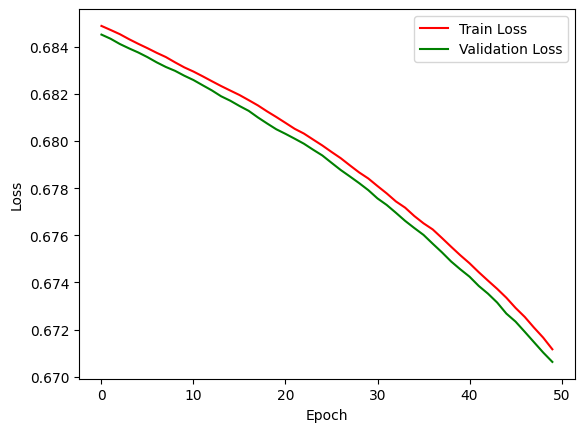

In [25]:
# Plot loss function for training and validation sets
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss', color='red')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])

##### $\color{red}{\text{This is for the Mastering Model Building exercise. Skip this block in your first pass!}}$

You might observe that your training hasn't converged yet, and you need to increase the number of training epochs.

It might also be that your model did converge, but you observe serious overtraining by comparing the training with the validation loss.

Or your convergence is just fine, and you don't see overtraining, but your model performance sucks.

In any case, try to improve your model training by what you have learned in the lecture. The red sections should provide you with some guidance, but feel free to add whatever you consider appropriate. Have fun!

## Evaluate Model Performance

So, how does our model perform? The losses only tell us that the model learns something. But it is unclear how well it does.

We need to evaluate this on an idependent dataset. Luckily, you have prepared an independent test dataset above!

1. Evaluate the model on the testing dataset.
3. Plot the distribution of scores, for each, true Signal and Background classes.
4. Compute various metrics
5. Plot ROC curve (example code given)

In [26]:
# Evaluate the model on the test dataset
# per default  PyTorch will add the predicted values to the computation graph
# Call the detach() method to remove them
y_pred = model(X_test_tensor).detach()

In [27]:
# Filter the predicted events for true Signal and true Background
true_signal = y_pred[y_test==1].numpy()
true_bkg = y_pred[y_test==0].numpy()

(0.0, 1.0)

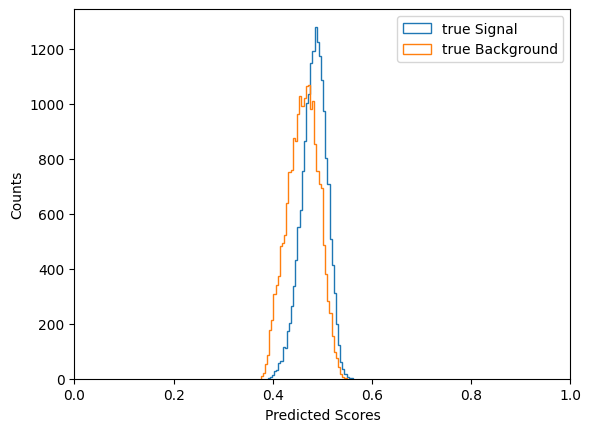

In [28]:
# Plot the predicted scores for both true Signal and true Background events
import matplotlib.pyplot as plt
plt.hist(true_signal, bins=40, histtype='step', label='Signal', density=False)
plt.hist(true_bkg, bins=40, histtype='step', label='Background', density=False)
plt.legend(["true Signal","true Background"])
plt.xlabel("Predicted Scores")
plt.ylabel("Counts")
plt.xlim((0,1))

#### Question!

From this visual help: Was your model able to distinguish Signal from Background?

#### Quantify how well your model did

Let's now compute the accuracy and some other metrics that quantify how well your model distinguished between Signal and Background.

Use the implementations for the metrics from [`sklearn.metrics`](https://scikit-learn.org/stable/api/sklearn.metrics.html).

In [29]:
# sklearn.metrics require exact value matches, so we need to round to 0 or 1
final_prediction_score =y_pred.numpy()
final_prediction = np.round(final_prediction_score)

In [30]:
# Compute the accuracy_score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, final_prediction)
print(accuracy)


0.5940706653972284


In [31]:
# Caclulate some other metrics that are suitable for a classification
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
precision = precision_score(y_test, final_prediction, average='weighted')
recall = recall_score(y_test, final_prediction, average='weighted')
f1 = f1_score(y_test, final_prediction, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.6324448044871155
Recall: 0.5940706653972284
F1 Score: 0.5440187125833956


#### The Receiver Operating Characteristic (ROC) curve

A common method in order to quantify how well a classifier performs is to look on the rate of false positives and true positive classifications.
The so-called Receiver Operating Characteristic (ROC) combines these into a single visual representation by plotting the two values in a 2D scatter.

However, with our NN model we have trained above, we can create an almost infinite number of classifiers (restricted only by the numerical precision), by varying the `Predicted Score` value at which we define the border between Signal and Background.

This gives us a quasi-continuous set of points in the aforementioned 2D scatter, a curve. We call this the ROC curve.
This is a common visual tool for comparing different classifier models, but we can also derive a quantifyable number related to this by computing the integral under this curve. Since it is measuring the **a**rea **u**nder the **c**urve, we call it ROC-AUC.

Again, we can use the implementations from sklearn.metrics for the `roc_curve` and also to compute the `auc`.

Plot the ROC curve and compute the ROC-AUC!

In [32]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test,final_prediction_score)

np.float64(0.7060698575203108)

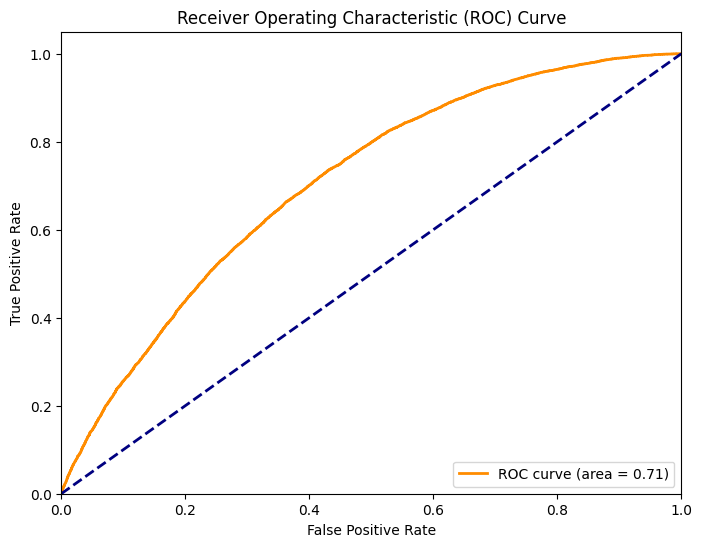

In [33]:
# Compute ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, final_prediction_score)

# Compute AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### Question!

How does your classifier perform in comparison to a random classification that assigns randomly 0 or 1 to an event with equal probability?

##### $\color{red}{\text{This is for the Mastering Model Building exercise. Skip this block in your first pass!}}$

You might have seen now, that even with a converging NN model your classification performance is far from optimal. Even if it is already very good, can you do better?

Try to improve your model by adjusting the architecture.
- Try using more layers or more nodes per layer.
- Review your choices for the activation functions.
- Also try to review what input features you feed the model.

Try whatever comes to your mind and you consider appropriate.

If you feel stuck, or you are bored, you might also find the following bonus tasks worth your time.
They might help you with winkling out the last bits of performance improvement.

## $\color{red}{\text{Bonus Tasks}}$


#### 1. Implement Early Stopping for your model training

In order to not manually tune the number of training epochs to avoid overtraining and find the optimal stopping point, try to implement early stopping into your model training.

To do so, use the provided class, but feel free to adjust whatever you like:

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience        # How many epochs to wait
        self.min_delta = min_delta      # Minimum improvement to count
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if improvement
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

And add the early stopping into your training loop. You could do it like this for example:
```python
for epoch in range(num_epochs):

    # --- Train ---
      .
      .
      .
    # --- Validate ---
      .
      .
      .
    # --- Check Early Stopping ---
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break
```
Feel free to adjust it to your needs.

#### 2. Adjust the learning rate during training

It might happen that at some point your training doesn't improve anymore and your losses are oscillating around.
This might be the perfect opportunity to check whetehr dynamically changing the learning rate might get you even closer to the minimum.

Use the instructions from the [PyTorch tutorial "How to adjust learning rate"](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) to add a learning rate scheduler (or multiple) that dynamically changes the learning rate.

The following method is a simple way of calculating the feature importance of the input dataset. It shuffles the values of one feature at a time into a random order (imagine the `df_signal` dataframe but with all the values in one column randomly shuffled). Since the values of this feature are now not correlated with the rest of the features in that datapoint (event), the performance should change. The extend to which the performance changes is a measure of the feature importance: if you shuffle `feature1` and very little changes, this tells us that `feature1` was not important to the model.

#### 3. Study the feature importance of your model

In [71]:
# Compute feature importance of 26 input features to DNN
import numpy as np
from sklearn.metrics import accuracy_score

def permutation_importance(model, X_val_tensor, y_val):

    detach_to_binary = lambda x: np.round(model(x).detach().numpy())

    baseline_score = accuracy_score(y_val, detach_to_binary(X_val_tensor))  # For a classification task
    importances = []

    for feature_idx in range(X_val_tensor.shape[1]):
        # Shuffle the values of the current feature
        X_val_shuffled = X_val_tensor.clone()
        X_val_shuffled[:, feature_idx] = X_val_shuffled[:, feature_idx][torch.randperm(X_val.shape[0])]

        # Recalculate the performance
        score_shuffled = accuracy_score(y_val, detach_to_binary(X_val_shuffled))
        print(score_shuffled)

        # The difference in performance is the importance of this feature
        importances.append(baseline_score - score_shuffled)

    return np.array(importances)

# Usage example
importances = permutation_importance(model, X_val_tensor, y_val_tensor)


0.8260076166296414
0.8278324341478895
0.8302390775415213
0.830106844388025
0.8266687823971226
0.8271183751190099
0.8310324764624987
0.8283349201311753
0.8272770549032054
0.8287580662223633
0.8298423780810325
0.8214587961493706
0.8276737543636941
0.8253200042314609
0.8304242039564159
0.8295250185126415
0.811197503438062
0.7736697344758278
0.8157198772876335
0.8309266899397016
0.8310853697238971
0.8206918438590923
0.8155876441341373
0.731196445572834
0.8282820268697768
0.7761028245001587


In [72]:
idx = np.argsort(np.asarray(importances))

In [73]:
df_background.columns.to_numpy()[:23]

array(['lepton0_px', 'lepton0_py', 'lepton0_pz', 'lepton0_energy',
       'lepton1_px', 'lepton1_py', 'lepton1_pz', 'lepton1_energy',
       'jet0_px', 'jet0_py', 'jet0_pz', 'jet0_energy', 'jet1_px',
       'jet1_py', 'jet1_pz', 'jet1_energy', 'Njets', 'HT_all',
       'MissingEnergy', 'lepton0_mass', 'lepton1_mass', 'jet0_mass',
       'jet1_mass'], dtype=object)

In [74]:
sorted_features_descending = df_background.columns.to_numpy()[idx]

for i in range(len(sorted_features_descending)):
    print(f"Feature: {sorted_features_descending[i]}, Importance: {importances[idx[i]]:.4f}")

Feature: lepton1_mass, Importance: 0.0001
Feature: lepton1_pz, Importance: 0.0002
Feature: lepton0_mass, Importance: 0.0003
Feature: jet1_pz, Importance: 0.0008
Feature: lepton0_pz, Importance: 0.0010
Feature: lepton0_energy, Importance: 0.0011
Feature: jet0_pz, Importance: 0.0014
Feature: jet1_energy, Importance: 0.0017
Feature: jet0_py, Importance: 0.0025
Feature: lepton1_energy, Importance: 0.0029
Feature: angle_between_jets, Importance: 0.0029
Feature: lepton0_py, Importance: 0.0034
Feature: jet1_px, Importance: 0.0035
Feature: jet0_px, Importance: 0.0039
Feature: lepton1_py, Importance: 0.0041
Feature: lepton1_px, Importance: 0.0045
Feature: lepton0_px, Importance: 0.0052
Feature: jet1_py, Importance: 0.0059
Feature: jet0_energy, Importance: 0.0098
Feature: jet0_mass, Importance: 0.0105
Feature: MissingEnergy, Importance: 0.0155
Feature: jet1_mass, Importance: 0.0156
Feature: Njets, Importance: 0.0200
Feature: angle_between_leptons, Importance: 0.0551
Feature: HT_all, Importance: 

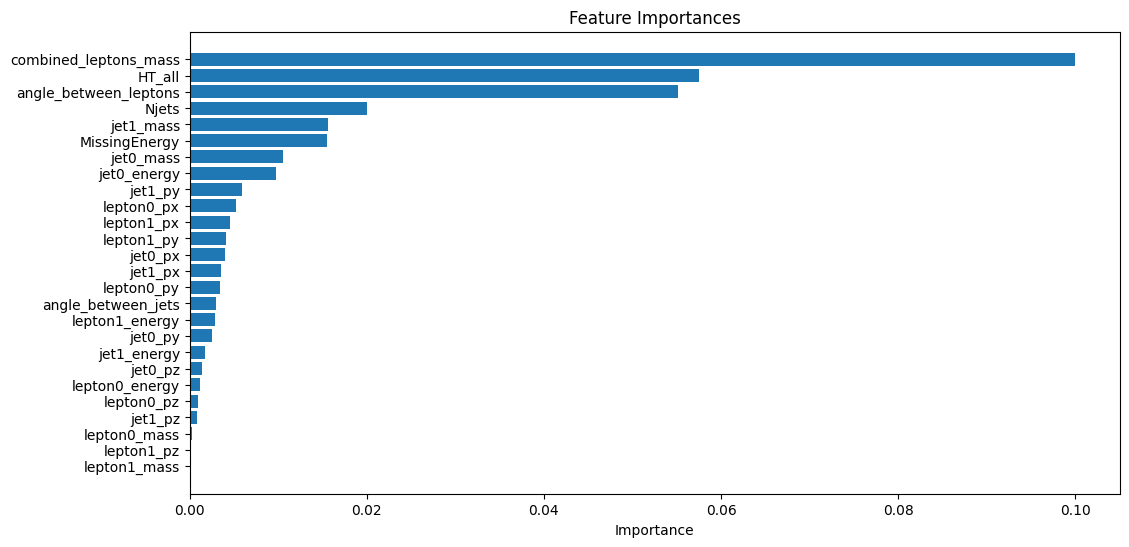

In [75]:
# Plot feature importances
import matplotlib.pyplot as plt
importances = importances[idx]
plt.figure(figsize=(12, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), sorted_features_descending)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

#### 4. Use the `nn.Module` functionality

So far we have defined our models using `nn.Sequential`, which is a concise and readable syntax for MLPs.

For more complex models, or architectures which will contain multiple MLPs in different roles, it may be preferable to use PyTorch's `nn.Module` which defines a Python class. `nn.Module` is much more powerful and flexible, although contains more "boiler-plate code". It is instructive good to see this syntax and become familiar with "overriding" base PyTorch classes.

The class contains:
1. An `__init__` method (as required by all Python classes if you know OOP-Python). Here we define our `Linear` layers.
2. A `forward` method that controls the forward flow of data through the network. Here we order our `Linear` layers and apply our activation functions. (The preferred approach is to include the activation functions in the `forward` method rather than the `__init__`)

The code below defines a class `SimpleDNN` which has two layers. Make sure you understand what this code is doing!

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleDNN(nn.Module):
    def __init__(self, N_input_features): # You can add more parameters here, such that the size of all layers can be
        # defined in the constructor
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(SimpleDNN, self).__init__()
        self.linear1 = nn.Linear(N_input_features, 50)
        self.linear2 = nn.Linear(50, 1)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # Compute the forward pass. 
        # The first layer is self.linear1, then we apply the ReLU activation function
        x1     = F.relu(self.linear1(x))
        # The second layer is self.linear2, then we apply the sigmoid activation function to get our final output
        y_pred = F.sigmoid(self.linear2(x1))
        return y_pred

You then call your model in exactly the same way as we did when `model = nn.Sequential(...)`:

In [7]:
model = SimpleDNN(3)
model(X_train_tensor)

NameError: name 'X_train_tensor' is not defined

Task: can you re-write your best performing DNN using `nn.Module`, and can include dropout in the `__init__`